# Exploratory Data Analysis -- Mint.com Food Transactions
---------------------------------
By: Eric Bauer

### Goal: Identify any time-series trends in Food spending, especially for Groceries vs. Eating Out

# 1. Load the Transaction Data

In [1]:
import pandas as pd
import os

data_paths = {'in':'../../data/raw',
              'out':'../../data/processed',
             }

In [2]:
# select which data set to explore
data_select = {'eric': 'transactions_eric.csv',
               'amanda': 'transactions_amanda.csv'
              }
select = 'eric'

In [3]:
df = pd.read_csv(os.path.join(data_paths['in'], data_select[select]))
df.iloc[10:16] # note: index window chosen to prevent income related info from displaying

,Date,Description,Original Description,Amount,Transaction Type,Category,Account Name,Labels,Notes
10,4/14/2020,payment Citi Autopay,Web Authorized Pmt Citi Autopay,25.00,debit,Credit Card Payment,Checking,NaN,NaN
11,4/14/2020,Wal-Mart,WALMART.COM 800-966-6546 AR,31.82,debit,Pet Food & Supplies,Citi Premier℠ Card,NaN,NaN
12,4/14/2020,Amazon Fresh,AMAZON FRESH*8J00J0773 AMZN.COM/BILL WA,45.19,debit,Groceries,Citi Premier℠ Card,NaN,NaN
13,4/13/2020,Autopay Rautopay Auto,AUTOPAY 190718060634561RAUTOPAY AUTO-PMT,25.00,credit,Income,Citi Premier℠ Card,NaN,NaN
14,4/13/2020,payment Citi Card Online,Web Authorized Pmt Citi Card Online,2842.47,debit,Credit Card Payment,Checking,NaN,NaN
15,4/12/2020,"Oakland Nursery, Inc.",OAKLAND NURSERY DUBLIN OH,66.49,debit,Lawn & Garden,Citi Premier℠ Card,NaN,NaN


**Note**: We can already see that the Income Category has the same sign as other expenses. We'll change this later

In [4]:
# print the data schema as read in by pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312 entries, 0 to 6311
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6312 non-null   object 
 1   Description           6312 non-null   object 
 2   Original Description  6312 non-null   object 
 3   Amount                6312 non-null   float64
 4   Transaction Type      6312 non-null   object 
 5   Category              6312 non-null   object 
 6   Account Name          6312 non-null   object 
 7   Labels                5 non-null      object 
 8   Notes                 1 non-null      object 
dtypes: float64(1), object(8)
memory usage: 246.6+ KB


In [5]:
# change the column names to lower case and underscores for ease of use
col_parser = lambda x: '_'.join(x.lower().split(' '))
df.rename(col_parser, axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312 entries, 0 to 6311
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  6312 non-null   object 
 1   description           6312 non-null   object 
 2   original_description  6312 non-null   object 
 3   amount                6312 non-null   float64
 4   transaction_type      6312 non-null   object 
 5   category              6312 non-null   object 
 6   account_name          6312 non-null   object 
 7   labels                5 non-null      object 
 8   notes                 1 non-null      object 
dtypes: float64(1), object(8)
memory usage: 246.6+ KB


In [6]:
# grab only the columns of interest
columns_to_keep = ['date','description','amount','category'] 
df = df.loc[:, columns_to_keep]  # or just: df = df[columns_to_keep]

In [7]:
# convert 'date' column to datetime object
df['date'] = pd.to_datetime(df['date'])
# set 'date' as index
df.set_index('date', inplace=True)
df.loc['4/12/2020':'4/14/2020'] # note: index window chosen to prevent income related info from displaying

,description,amount,category
date,,,
2020-04-14,payment Citi Autopay,25.00,Credit Card Payment
2020-04-14,Wal-Mart,31.82,Pet Food & Supplies
2020-04-14,Amazon Fresh,45.19,Groceries
2020-04-13,Autopay Rautopay Auto,25.00,Income
2020-04-13,payment Citi Card Online,2842.47,Credit Card Payment
2020-04-12,"Oakland Nursery, Inc.",66.49,Lawn & Garden


In [8]:
# convert 'category' column into category object (duh)
df['category'] = df['category'].astype('category')

# describe the categories
cats = df['category'].unique()
print(f'There are {len(cats)} unique categories')
pd.Series(cats).head(5)

There are 104 unique categories


0             Shopping
1               Income
2      Mortgage & Rent
3            Groceries
4    Business Services
dtype: category
Categories (104, object): [Shopping, Income, Mortgage & Rent, Groceries, ..., Uncategorized, Student Loan, Laundry, Cryptocurrency]

In [9]:
df['category'].value_counts().head(10) 

Groceries        647
Fast Food        633
Shopping         602
Restaurants      538
Transfer         445
Work Food        418
Uncategorized    359
Income           277
Gas & Fuel       220
Books            184
Name: category, dtype: int64

In [10]:
# Check transactions that might be negative expenses (aka. Income).....Cross-ref with Mint.com
income_cats = ['Reimbursement','Bonus','Interest Income','Income'] # note State Tax and Federal Tax are a mixed sign category
filt = (df['category'].isin(income_cats))
df.loc[filt, 'amount'] = df.loc[filt, 'amount'].apply(lambda x: x*(-1))
# note: transformation not displayed to prevent income related info from displaying

# 2. Aggregate Transaction Data

## 2a. Find the Total Top 10 Spending Categories

In [11]:
total_top10 = df.groupby('category', as_index=False).sum()

In [12]:
total_top10 = df.groupby('category', as_index=False).sum().nlargest(10, 'amount')
total_top10.reset_index(drop=True)

,category,amount
0,Credit Card Payment,142966.23
1,Transfer,98566.97
2,Mortgage & Rent,29873.95
3,Shopping,24274.75
4,Check,21539.53
5,Groceries,20583.42
6,Restaurants,11575.76
7,Wedding,9261.70
8,Auto & Transport,8997.91
9,Uncategorized,7809.87


## 2b. Find Top 10 Categories for Past 5 Years

In [13]:
years = list(range(2016, 2021))
years = [str(x) for x in years]

In [14]:
top10 = []
for year in years:
    top = df.loc[year, :].groupby('category').sum().nlargest(10, 'amount').reset_index()
    top10.append(top)

In [15]:
for i, year in enumerate(years):
    print(f'For the year {year}, the top 10 expenses were:')
    print(top10[i])
    print()

For the year 2016, the top 10 expenses were:
          category   amount
0         Transfer  9411.39
1            Check  8531.34
2         Shopping  8071.06
3        Groceries  3318.80
4         Clothing  3094.52
5    Uncategorized  2927.49
6        Fast Food  2441.25
7     Student Loan  2441.04
8      Restaurants  1391.11
9  Service & Parts  1306.10

For the year 2017, the top 10 expenses were:
              category    amount
0  Credit Card Payment  14858.66
1             Transfer   7161.00
2          Credit Card   6204.41
3     Hiking & Camping   3838.40
4              Hobbies   3361.80
5   Conference Expense   2685.36
6            Groceries   2005.41
7             Shopping   1535.62
8          Restaurants   1496.33
9            Fast Food    867.23

For the year 2018, the top 10 expenses were:
              category    amount
0  Credit Card Payment  47145.79
1             Transfer  13260.83
2      Mortgage & Rent   8434.43
3             Shopping   5614.48
4            Groceries   38

It appears that groceries appears in the top 10 for all of the last 5 years. This makes sense considering it is #6 in the total list

## 2c. Track Food Spending

In [16]:
# create a data frame where only food transactions are present
food_categories = ['Groceries','Work Food','Fast Food','Restaurants']
filt = df['category'].isin(food_categories)
food_df = df.loc[filt,:].copy()  # explicitly tell pandas to copy data frame so we avoid SettingWithCopyWarning
# see https://www.dataquest.io/blog/settingwithcopywarning/ for more

In [17]:
# get rid of the unused categories so they don't show up later in aggregation
food_df['category'].cat.remove_unused_categories(inplace=True)

In [18]:
# create a new time indexer
food_df['year-month'] = food_df.index.to_series().dt.to_period('M')

In [19]:
food_spending = food_df.groupby(['year-month', 'category']).sum().reset_index(drop=False)
food_spending.tail(9)

,year-month,category,amount
331,2020-02,Work Food,NaN
332,2020-03,Fast Food,20.67
333,2020-03,Groceries,710.92
334,2020-03,Restaurants,17.90
335,2020-03,Work Food,NaN
336,2020-04,Fast Food,NaN
337,2020-04,Groceries,157.65
338,2020-04,Restaurants,NaN
339,2020-04,Work Food,NaN


Because Restaurants, Work Food and Fast Food categories are not all consistently attributed over the years.

Hence, these need to be combined into a new composite category of **Eating Out** for comparison with Groceries

In [20]:
# Add the new category
food_spending['category'] = food_spending['category'].cat.add_categories('Eating Out')

In [21]:
# replace all non-Grocery categories with 'Eating Out'
eat_out_cat_list = ['Work Food','Fast Food','Restaurants']
food_spending['category'] = food_spending['category'].replace({x:'Eating Out' for x in eat_out_cat_list}) 
# note: use replace on the series rather than map, since the latter will map Groceries to NaN

In [22]:
# Aggregate Food spending by Year-Month and then by Category using the sum function
food_spending = food_spending.groupby(['year-month','category']).sum().reset_index()
# Convert 'year-month' from a Period type to a timestamp type
food_spending['year-month'] = food_spending['year-month'].apply(lambda x: x.to_timestamp()) # convert to timestamp 

In [23]:
food_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year-month  170 non-null    datetime64[ns]
 1   category    170 non-null    object        
 2   amount      170 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.4+ KB


In [24]:
# create the series for plotting
eating_out = food_spending[food_spending['category']=='Eating Out'].reset_index(drop=True)
groceries = food_spending[food_spending['category']=='Groceries'].reset_index(drop=True)

# 3. Plot Relevant Data

In [25]:
# plot helper functions
def newyear(date):
    if date.month == 1: # If the month is January, it is a new year
        return True
    else:
        return False
    
def dateaxis_labelmaker(date):
    if newyear(date): # If the month is January, print out the Year and Month
        label = f'{date.year} - {date.month_name()[0:3]}.'
    else: # if not January, return just Month
        label = f'{date.month_name()[0:3]}.'
    return label



In [26]:
# create a major tick list
filt = eating_out['year-month'].apply(newyear)
major_ticks_list = eating_out.loc[filt,'year-month'].reset_index(drop=True)

In [27]:
%matplotlib inline

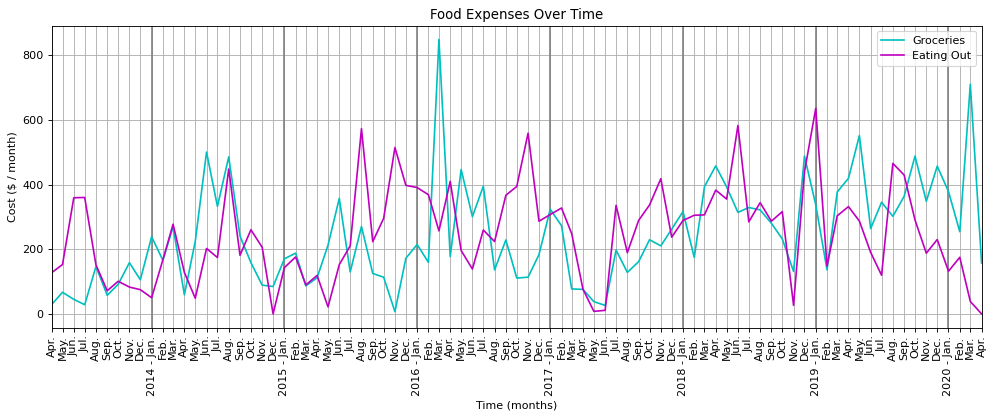

In [28]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# add major ticks and x-labels
for i in range(0,len(major_ticks_list)):
    plt.axvline(x=major_ticks_list[i], ymin=0, ymax=1, c='gray')
plt.xticks(eating_out['year-month'],eating_out['year-month'].apply(dateaxis_labelmaker), rotation=90)

# plot the time-series data
plt.plot(groceries['year-month'], groceries['amount'], c='c', label='Groceries')
plt.plot(eating_out['year-month'], eating_out['amount'], c= 'm', label='Eating Out')

# describe the graph
plt.legend()
plt.title('Food Expenses Over Time')
plt.xlabel('Time (months)')
plt.ylabel('Cost ($ / month)')
plt.xlim([eating_out['year-month'].min(), eating_out['year-month'].max()])
plt.grid()
plt.show()

### Obervation: 
The groceries and eating out seem to mostly be in-phase (or near 0 degree lag/lead). This is broken from Aug 2015 to Jan 2017, where the signals are almost 180 out of phase. This suggests an interesting relationship if the data is correct.

To investigate the synchronicity some further time-series analysis can be done: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

---------------------------------------------------------

As we will see below, the top 10 expenses for 2015 and 2016 (in the Food categories) are actually pizza orders made for Electronics Club. During this time, I often floated these expenses on my account to make sure the club could still hold meetings without waiting for chicken-and-egg cashflows like E-Council volunteering hours to cash out. This bankrolling culminated on March 04, 2016 for the second annual Makeathon when I did a grocery trip to Costco for $683. The funds for this event were not fully liquid at the time of its launch.

After the Makeathon, I was eventually repaid for my pizza and Costco purchases, but the reimbursements were so aggregated that it was hard to track which thing was being repaid. Thus, the data for this period was never adjusted.

After graduated in May 2016, I went down to Dallas to work at TI for the summer before grad school. Grocery bills were high, as was eating out since I had a larger income level. Upon returning to Ohio State and starting grad school, my free time and organization went to zero. Eating out peaked again around November 2016 as Karun and I finished up a 50 hour paper writing session right before Thanksgiving break. 

The perhaps final anomaly is the dip in *all* food spending from April to June 2017. I'm not sure what happened here. Perhaps the data is mislabeled during this period or I was in a communal grocery situation with the Dublin House guys.

In [29]:
# Create a Spending Difference signal
diff = groceries['amount'] - eating_out['amount']

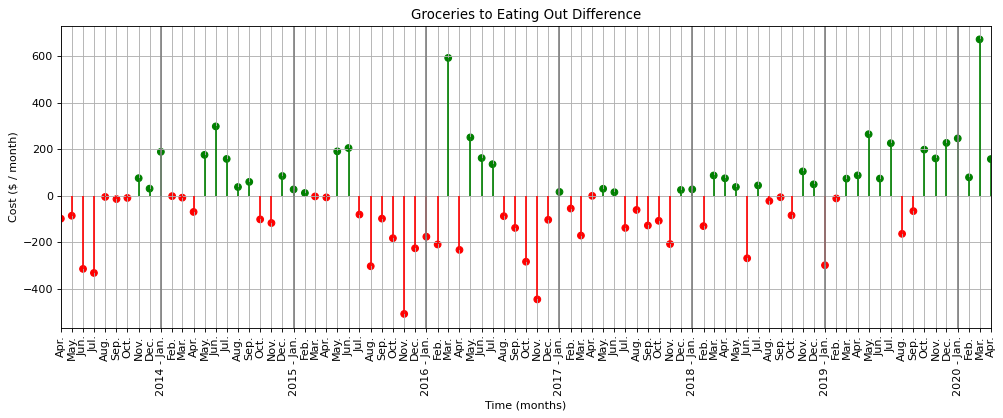

In [30]:
import numpy as np
col = np.where(diff >=0, 'g', 'r')

fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# add major ticks and x-labels
for i in range(0,len(major_ticks_list)):
    plt.axvline(x=major_ticks_list[i], ymin=0, ymax=1, c='gray')
plt.xticks(eating_out['year-month'],eating_out['year-month'].apply(dateaxis_labelmaker), rotation=90)

# janky stem plot
plt.scatter(groceries['year-month'], diff, c=col, label='Difference')
plt.vlines(groceries['year-month'], ymin=0, ymax=diff, color=col)

# describe the plot
plt.title('Groceries to Eating Out Difference')
plt.xlabel('Time (months)')
plt.ylabel('Cost ($ / month)')
plt.xlim([eating_out['year-month'].min(), eating_out['year-month'].max()])
plt.grid()
plt.show()

**Note**: Thug Kitchen Ordered on May 10, 2018

**Note**: Started Dating Amanda on June 24, 2017

In [31]:
food_df.loc['2016'].nlargest(10, 'amount')

,description,amount,category,year-month
date,,,,
2016-03-04,Costco,684.32,Groceries,2016-03
2016-05-16,Wal-Mart,213.28,Groceries,2016-05
2016-09-02,Domino's Pizza,167.98,Fast Food,2016-09
2016-01-29,Domino's Pizza,126.99,Fast Food,2016-01
2016-09-14,Domino's Pizza,119.91,Fast Food,2016-09
2016-02-12,Domino's Pizza,116.99,Fast Food,2016-02
2016-04-08,Domino's Pizza,112.99,Fast Food,2016-04
2016-04-15,Domino's Pizza,110.99,Fast Food,2016-04
2016-10-21,Domino's Pizza,106.49,Fast Food,2016-10


**Note**: The period of heavy fast food spending is from bankrolling Electronics Club temporarily

In [32]:
food_df.loc['2015'].nlargest(10, 'amount')

,description,amount,category,year-month
date,,,,
2015-08-28,Adriatico Pizz,325.78,Restaurants,2015-08
2015-05-18,Hy-Vee,156.82,Groceries,2015-05
2015-06-03,Hy-Vee,131.86,Groceries,2015-06
2015-10-09,Pizza Joint,120.00,Restaurants,2015-10
2015-12-04,Domino's Pizza,115.06,Fast Food,2015-12
2015-11-06,Domino's Pizza,115.00,Fast Food,2015-11
2015-11-20,Domino's Pizza,91.99,Fast Food,2015-11
2015-07-06,Bravo Jordan,90.00,Restaurants,2015-07
2015-11-19,Domino's Pizza,86.99,Fast Food,2015-11


**Note**: The same was true for 2015. The top expense was the 1st meeting of E club after involvement fair

## 3b. Is there a Monthly trend ?

In [33]:
food_spending2 = food_spending.copy()
# add a month_name column to aggregate on later
food_spending2['month_name'] = food_spending2['year-month'].apply(lambda x: x.month_name())
# set 'year-month' as an index so that it is sliceable later
food_spending2.set_index('year-month', inplace=True)

In [34]:
# Create the time filter
filt = (food_spending2.index < '2015-08-01') | (food_spending2.index >= '2016-05-01')
food_spending2 = food_spending2.loc[filt,:]

In [35]:
spend_by_month = food_spending2.groupby(['month_name', 'category'], as_index=False).mean()
spend_by_month.head(5)

,month_name,category,amount
0,April,Eating Out,166.725714
1,April,Groceries,187.427143
2,August,Eating Out,304.000000
3,August,Groceries,253.608333
4,December,Eating Out,211.550000


In [36]:
# Get the sorting of the months to be in sequential order, not alphabetical
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['January','February','March','April','May','June',
                                   'July','August','September','October','November','December'],
                            ordered=True)
spend_by_month['month_name'] = spend_by_month['month_name'].astype(cat_type)
spend_by_month = spend_by_month.set_index('month_name').sort_index()

In [37]:
spend_by_month.head(5)

,category,amount
month_name,,
January,Eating Out,259.831667
January,Groceries,294.473333
February,Eating Out,216.698333
February,Groceries,198.806667
March,Groceries,319.296667


In [38]:
groceries_filt = (spend_by_month['category'] == 'Groceries')
groceries = spend_by_month.loc[groceries_filt,:]

In [39]:
eatout_filt = (spend_by_month['category'] == 'Eating Out')
eatout = spend_by_month.loc[eatout_filt,:]

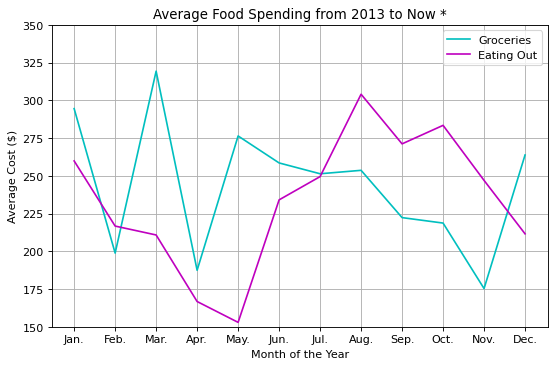

In [40]:
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(groceries.index, groceries['amount'], color='c', label='Groceries')
plt.plot(eatout.index, eatout['amount'], color='m', label='Eating Out')

locs, labels = plt.xticks()
labels = eatout.index.categories.to_list()
plt.xticks(locs, [x[0:3]+'.' for x in labels], rotation=0)

# describe the plot
plt.title('Average Food Spending from 2013 to Now *')
plt.xlabel('Month of the Year')
plt.ylabel('Average Cost ($)')
plt.grid()
plt.legend()
plt.ylim([150, 350])
plt.show()

***Note: the August 2015 to April 2016 time period is discounted due to erroneous data**

This time series graph is the clearest representation of the data

## 3c. What does monthly trend look like without COVID Outlier?

In [41]:
# Create the time filter
filt = (food_spending2.index < '2015-08-01') | ((food_spending2.index >= '2016-05-01')&(food_spending2.index < '2020-03-01')) 
food_spending2 = food_spending2.loc[filt,:]

In [42]:
spend_by_month = food_spending2.groupby(['month_name', 'category'], as_index=False).mean()
spend_by_month.head(5)

,month_name,category,amount
0,April,Eating Out,194.513333
1,April,Groceries,192.390000
2,August,Eating Out,304.000000
3,August,Groceries,253.608333
4,December,Eating Out,211.550000


In [43]:
# Get the sorting of the months to be in sequential order, not alphabetical
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['January','February','March','April','May','June',
                                   'July','August','September','October','November','December'],
                            ordered=True)
spend_by_month['month_name'] = spend_by_month['month_name'].astype(cat_type)
spend_by_month = spend_by_month.set_index('month_name').sort_index()

In [44]:
groceries_filt = (spend_by_month['category'] == 'Groceries')
groceries = spend_by_month.loc[groceries_filt,:]

In [45]:
eatout_filt = (spend_by_month['category'] == 'Eating Out')
eatout = spend_by_month.loc[eatout_filt,:]

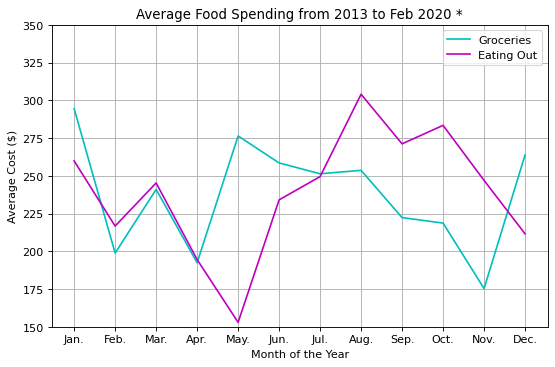

In [46]:
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(groceries.index, groceries['amount'], color='c', label='Groceries')
plt.plot(eatout.index, eatout['amount'], color='m', label='Eating Out')

locs, labels = plt.xticks()
labels = eatout.index.categories.to_list()
plt.xticks(locs, [x[0:3]+'.' for x in labels], rotation=0)

# describe the plot
plt.title('Average Food Spending from 2013 to Feb 2020 *')
plt.xlabel('Month of the Year')
plt.ylabel('Average Cost ($)')
plt.grid()
plt.legend()
plt.ylim([150, 350])
plt.show()

***Note: the August 2015 to April 2016 time period is discounted due to erroneous data**

**Eating Out** -- There is a clear seasonal trend in the Eating Out time series. Over the period of a year, Eating Out spending varies sinusoidally with an amplitude of roughly \\$75 and an average of \\$225 spent each month on Eating Out.

**Groceries** -- Even without COVID's March Grocery shopping spree, the March average spending is higher that neighboring months. Despite that, a weaker cosinudoidal trend can be seen with Groceries spending. The spending has an average of \\$240 with an amplitude of roughly \\$40.

The trends noted for Eating Out and Groceries are linked by a few common causes. 
1. Most of the data is from years in college where I completed a summer internship. These internships would typically start in May and go until August. My eating out spending would ramp up with my income and then steadily coast down again till next May as my finite cash pile dwindled. Grocery spending typically rose when Eating Out fell since groceries were a more cost efficient way to feed myself.
2. Eating Out peaks typically corresponded to the start of a college semester (Aug. & Jan.) as well as heavy midterm season (Oct. & Mar.)